## Verification of new GroupBy transformer
* based on "Tutorial_2. AutoML pipeline preset"
* added "Step 3.0 Modify classes for GroupBy" 
* changed "Step 3.1. Create AutoML from preset" to use pipeline with GroupBy transformer

### before
* TIMEOUT = 1200
    * [2021-08-29 09:58:14,770] (INFO): OOF score: 0.75402721996973
    * [2021-08-29 09:58:14,773] (INFO): TEST score: 0.7332982336956523
* TIMEOUT = 180
    * [2021-08-29 10:13:22,973] (INFO): OOF score: 0.7529039502908255
    * [2021-08-29 10:13:22,975] (INFO): TEST score: 0.7309205163043477
    
### after
* TIMEOUT = 1200
    * [2021-08-30 11:03:54,557] (INFO): OOF score: 0.7539002980432976
    * [2021-08-30 11:03:54,558] (INFO): TEST score: 0.7339538043478261
* TIMEOUT = 180
    * [2021-08-30 10:29:37,991] (INFO): OOF score: 0.7528966156066348
    * [2021-08-30 10:29:37,993] (INFO): TEST score: 0.7309918478260871

### configuration - default:
* 5 categorial
* 5 numeric

# Step 0.0. Install LightAutoML

Uncomment if doesn't clone repository by git. (ex.: colab, kaggle version)

In [33]:
#! pip install -U lightautoml

# Step 0.1. Import necessary libraries 

In [34]:
# Standard python libraries
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

# Step 0.2. Parameters 

In [35]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 180 # Time in seconds for automl run
TARGET_NAME = 'TARGET' # Target column name

# Step 0.3. Fix torch number of threads and numpy seed 

In [36]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Example data load 

Load a dataset from the repository if doesn't clone repository by git.

In [37]:
DATASET_DIR = './example_data/test_data_files'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/example_data/test_data_files/sampled_app_train.csv'

In [38]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

Wall time: 999 µs


In [39]:
%%time

data = pd.read_csv(DATASET_FULLNAME)
data.head()

Wall time: 150 ms


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


# Step 0.5. (Optional) Some user feature preparation 

Cell below shows some user feature preparations to create task more difficult (this block can be omitted if you don't want to change the initial data):

In [40]:
%%time

data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

data['constant'] = 1
data['allnan'] = np.nan

data['report_dt'] = np.datetime64('2018-01-01')

data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

Wall time: 170 ms


# Step 0.6. (Optional) Data splitting for train-test 

Block below can be omitted if you are going to train model only or you have specific train and test files:

In [41]:
%%time

train_data, test_data = train_test_split(data, 
                                         test_size=TEST_SIZE, 
                                         stratify=data[TARGET_NAME], 
                                         random_state=RANDOM_STATE)
logging.info('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

[2021-08-30 11:13:12,512] (INFO): Data splitted. Parts sizes: train_data = (8000, 125), test_data = (2000, 125)


Wall time: 21 ms


In [42]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0.0,0.0,0.0,1.0,0.0,1985-06-28,2012-06-21,1,NaN,2018-01-01
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0.0,0.0,0.0,0.0,3.0,1953-12-27,2018-01-01,1,NaN,2018-01-01
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0.0,0.0,0.0,0.0,2.0,1975-06-21,2016-06-17,1,NaN,2018-01-01
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,NaN,NaN,NaN,NaN,NaN,1988-04-27,2009-06-05,1,NaN,2018-01-01
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0.0,0.0,0.0,0.0,2.0,1975-06-13,1997-01-22,1,NaN,2018-01-01


# ========= AutoML preset usage =========


## Step 1. Create Task

In [43]:
%%time

task = Task('binary', )

Wall time: 6 ms


## Step 2. Setup columns roles

Roles setup here set target column and base date, which is used to calculate date differences:

In [44]:
%%time

roles = {'target': TARGET_NAME,
         DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt',
         }

Wall time: 0 ns


## Step 3.0 Modify classes for GroupBy

In [45]:
# helper classes with group_by features

from typing import Optional, Sequence
from lightautoml.automl.presets.base import AutoMLPreset
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.pipelines.features.linear_pipeline import LinearFeatures
from lightautoml.pipelines.ml.nested_ml_pipe import NestedTabularMLPipeline
from lightautoml.pipelines.features.lgb_pipeline import LGBAdvancedPipeline
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.base import FeaturesPipeline, TabularDataFeatures
from lightautoml.pipelines.features.linear_pipeline import NumpyOrPandas
from lightautoml.transformers.base import LAMLTransformer
from lightautoml.pipelines.selection.base import SelectionPipeline
from lightautoml.transformers.base import UnionTransformer

class LinearFeaturesWithGroupBy(LinearFeatures, FeaturesPipeline, TabularDataFeatures):
    def create_pipeline(self, train: NumpyOrPandas) -> LAMLTransformer:
        original = super().create_pipeline(train)
        group_by =  self.get_group_by(train)
        return UnionTransformer([original, group_by, ])

class LGBAdvancedPipelineWithGroupBy(LGBAdvancedPipeline, FeaturesPipeline, TabularDataFeatures):
    def create_pipeline(self, train: NumpyOrPandas) -> LAMLTransformer:
        original = super().create_pipeline(train)
        group_by =  self.get_group_by(train)
        return UnionTransformer([original, group_by])

class TabularAutoMLWithGroupBy(TabularAutoML, AutoMLPreset):
    def get_linear(self, n_level: int = 1, pre_selector: Optional[SelectionPipeline] = None) -> NestedTabularMLPipeline:

        # linear model with l2
        time_score = self.get_time_score(n_level, 'linear_l2')
        linear_l2_timer = self.timer.get_task_timer('reg_l2', time_score)
        linear_l2_model = LinearLBFGS(timer=linear_l2_timer, **self.linear_l2_params)

        # linear_l2_feats = LinearFeatures(output_categories=True, **self.linear_pipeline_params)
        linear_l2_feats = LinearFeaturesWithGroupBy(output_categories=True, **self.linear_pipeline_params)

        linear_l2_pipe = NestedTabularMLPipeline([linear_l2_model], force_calc=True, pre_selection=pre_selector,
                                                 features_pipeline=linear_l2_feats, **self.nested_cv_params)
        return linear_l2_pipe

    def get_gbms(self, keys: Sequence[str], n_level: int = 1, pre_selector: Optional[SelectionPipeline] = None,
                 ):

        # gbm_feats = LGBAdvancedPipeline(**self.gbm_pipeline_params)
        gbm_feats = LGBAdvancedPipelineWithGroupBy(**self.gbm_pipeline_params)

        ml_algos = []
        force_calc = []
        for key, force in zip(keys, [True, False, False, False]):
            tuned = '_tuned' in key
            algo_key = key.split('_')[0]
            time_score = self.get_time_score(n_level, key)
            gbm_timer = self.timer.get_task_timer(algo_key, time_score)
            if algo_key == 'lgb':
                gbm_model = BoostLGBM(timer=gbm_timer, **self.lgb_params)
            elif algo_key == 'cb':
                gbm_model = BoostCB(timer=gbm_timer, **self.cb_params)
            else:
                raise ValueError('Wrong algo key')

            if tuned:
                gbm_tuner = OptunaTuner(n_trials=self.tuning_params['max_tuning_iter'],
                                        timeout=self.tuning_params['max_tuning_time'],
                                        fit_on_holdout=self.tuning_params['fit_on_holdout'])
                gbm_model = (gbm_model, gbm_tuner)
            ml_algos.append(gbm_model)
            force_calc.append(force)

        gbm_pipe = NestedTabularMLPipeline(ml_algos, force_calc, pre_selection=pre_selector,
                                           features_pipeline=gbm_feats, **self.nested_cv_params)

        return gbm_pipe


## Step 3.1. Create AutoML from preset

To create AutoML model here we use `TabularAutoML` preset, which looks like:

![TabularAutoML preset pipeline](imgs/tutorial_blackbox_pipeline.png)

All params we set above can be send inside preset to change its configuration:

In [46]:
%%time 

# automl = TabularAutoML(
automl=TabularAutoMLWithGroupBy(
                       task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Start automl preset with listed constraints:
- time: 180 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (8000, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 146.89319014549255 secs
GroupByPipeline.create_pipeline.cat_feats_to_select:['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'EMERGENCYSTATE_MODE']
GroupByPipeline.create_pipeline.num_feats_to_select:['SK_ID_CURR', 'EXT_SOURCE_2', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1']
GroupByTransformer.__fit.begin
GroupByTransformer.__fit.type(dataset.data.to_numpy())=<class 'numpy.ndarray'>
GroupByTransformer.__fit.cat_cols=['fillnamed__le__CODE_GENDER', 'fillnamed__le__EMERGENCYSTATE_MODE', 'fillnamed__le__FLAG_OWN_CAR', 'fillnamed__le__FLAG_OWN_REALTY', 'fillnamed__le__NAME_CONTRACT_TYPE']
GroupByTransformer.__fit.num_cols:['DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'SK_ID_CURR']
GroupByTransformer.__fit.end

Model Lvl_0_Pipe_0_Mod_0_LinearL2 failed during ml_algo.fit_predict call.

all elements of input should be between 0 and 1


AssertionError: Pipeline finished with 0 models for some reason.
Probably one or more models failed

LightAutoML used 111 feats
1/111 Calculated score for OBS_30_CNT_SOCIAL_CIRCLE: 0.0008891
2/111 Calculated score for AMT_REQ_CREDIT_BUREAU_YEAR: 0.0046576
3/111 Calculated score for DAYS_REGISTRATION: 0.0069397
4/111 Calculated score for AMT_REQ_CREDIT_BUREAU_WEEK: 0.0000680
5/111 Calculated score for ENTRANCES_MEDI: 0.0001227
6/111 Calculated score for TOTALAREA_MODE: 0.0012031
7/111 Calculated score for FLOORSMAX_MODE: 0.0000355
8/111 Calculated score for YEARS_BUILD_MEDI: 0.0001928
9/111 Calculated score for CNT_CHILDREN: 0.0002128
10/111 Calculated score for LIVINGAREA_AVG: 0.0006642
11/111 Calculated score for ELEVATORS_MODE: 0.0001586
12/111 Calculated score for YEARS_BUILD_MODE: 0.0001458
13/111 Calculated score for LANDAREA_MODE: 0.0006678
14/111 Calculated score for FLAG_DOCUMENT_3: 0.0001805
15/111 Calculated score for EXT_SOURCE_3: 0.0459978
16/111 Calculated score for FLAG_CONT_MOBILE: -0.0000017
17/111 Calculated score for LANDAREA_AVG: 0.0006899
18/111 Calculated score fo

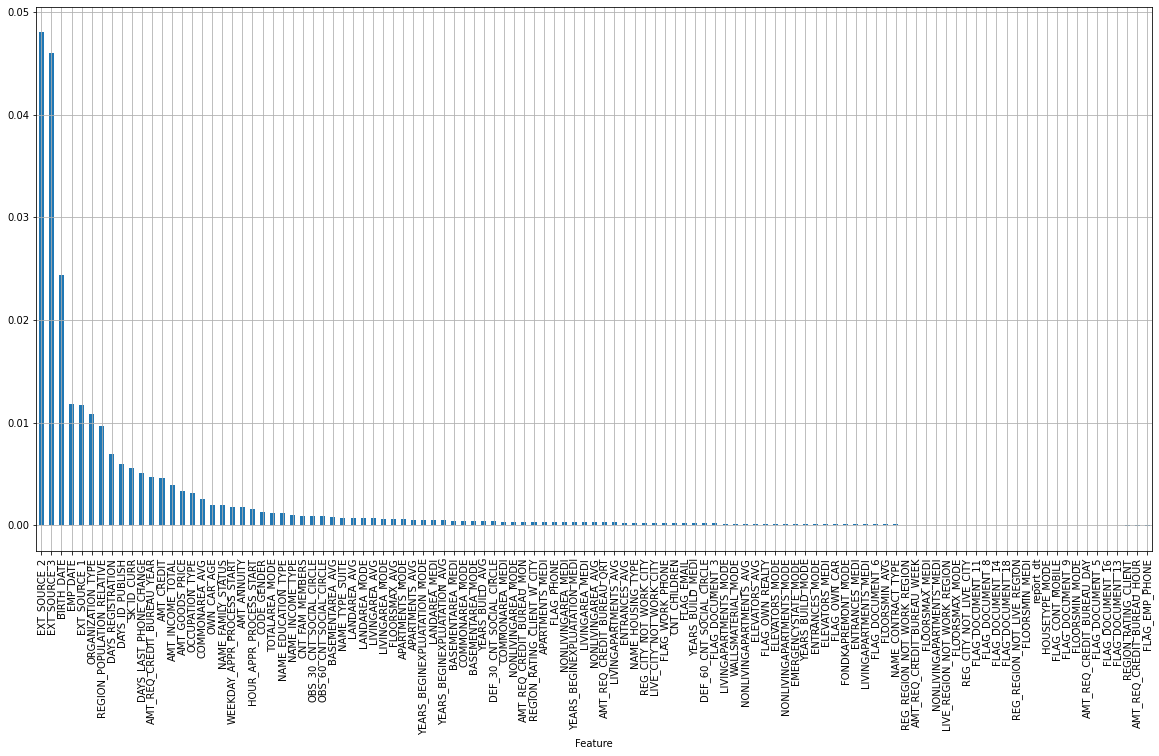

In [53]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
if fast_fi is None:
    fast_fi = automl.get_feature_scores('accurate', train_data, silent=False)
if fast_fi is not None:
    fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

LightAutoML used 111 feats
1/111 Calculated score for OBS_30_CNT_SOCIAL_CIRCLE: -0.0009579
2/111 Calculated score for AMT_REQ_CREDIT_BUREAU_YEAR: 0.0014742
3/111 Calculated score for DAYS_REGISTRATION: -0.0035802
4/111 Calculated score for AMT_REQ_CREDIT_BUREAU_WEEK: 0.0001664
5/111 Calculated score for ENTRANCES_MEDI: 0.0000204
6/111 Calculated score for TOTALAREA_MODE: -0.0005978
7/111 Calculated score for FLOORSMAX_MODE: 0.0007167
8/111 Calculated score for YEARS_BUILD_MEDI: 0.0001325
9/111 Calculated score for CNT_CHILDREN: -0.0000510
10/111 Calculated score for LIVINGAREA_AVG: 0.0005876
11/111 Calculated score for ELEVATORS_MODE: -0.0000034
12/111 Calculated score for YEARS_BUILD_MODE: 0.0001902
13/111 Calculated score for LANDAREA_MODE: 0.0007677
14/111 Calculated score for FLAG_DOCUMENT_3: 0.0011277
15/111 Calculated score for EXT_SOURCE_3: 0.0398743
16/111 Calculated score for FLAG_CONT_MOBILE: -0.0005027
17/111 Calculated score for LANDAREA_AVG: 0.0008594
18/111 Calculated sco

<AxesSubplot:xlabel='Feature'>

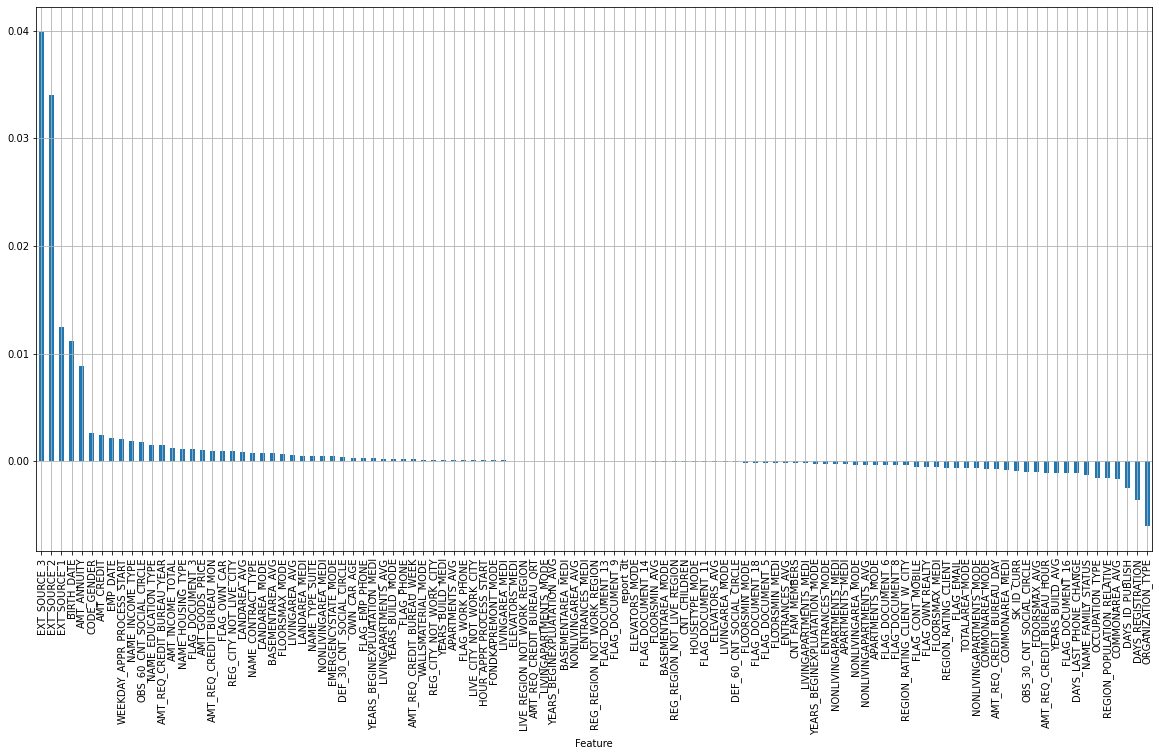

In [54]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl.get_feature_scores('accurate', test_data, silent = False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

## Step 4. Predict to test data and check scores

In [55]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-08-30 11:26:20,370] (INFO): Prediction for test data:
array([[0.03973391],
       [0.04812851],
       [0.02111761],
       ...,
       [0.0412482 ],
       [0.03729474],
       [0.16197851]], dtype=float32)
Shape = (2000, 1)
[2021-08-30 11:26:20,371] (INFO): Check scores...
[2021-08-30 11:26:20,375] (INFO): OOF score: 0.7528774816478762
[2021-08-30 11:26:20,378] (INFO): TEST score: 0.7312228260869565


Wall time: 1.13 s


## Step 5. Create AutoML with time utilization 

Below we are going to create specific AutoML preset for TIMEOUT utilization (try to spend it as much as possible):

In [56]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 8, 'cv': 5, 'random_state': 42}
Start automl preset with listed constraints:
- time: 179.99799871444702 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (8000, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 166.3980827331543 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6866430392738585
Linear model: C = 5e-05 score = 0.7052562930651998
Linear model: C = 0.0001 score = 0.7205499516226459
Linear model: C = 0.0005 score = 0.7546706865307824
Linear model: C = 0.001 score = 0.7616947576054012
Linear model: C = 0.005 score = 0.7632984268005196
Linear model: C = 0.01 score = 0.7604064766853227
Linear model: C = 0.0

Time limit exceeded after calculating fold 2


[600]	valid's auc: 0.728792
Early stopping, best iteration is:
[400]	valid's auc: 0.72972
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Optuna may run 1 secs


[2021-08-30 11:26:57,627] (INFO): A new study created in memory with name: no-name-7776648c-6c9e-4c84-aea9-a4c03ca08f98


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.746711
[200]	valid's auc: 0.747107
[300]	valid's auc: 0.747716
[400]	valid's auc: 0.74932
[500]	valid's auc: 0.753067
[600]	valid's auc: 0.752928
[700]	valid's auc: 0.754671
[800]	valid's auc: 0.753719
Early stopping, best iteration is:
[694]	valid's auc: 0.754767
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-08-30 11:27:24,998] (INFO): Trial 0 finished with value: 0.7547669066824895 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.7547669066824895.


Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	test: 0.4944593	best: 0.4944593 (0)	total: 5.77ms	remaining: 28.8s
100:	test: 0.7482720	best: 0.7498436 (92)	total: 512ms	remaining: 24.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7498436423
bestIteration = 92

Shrink model to first 93 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	test: 0.5681630	best: 0.5681630 (0)	total: 4.69ms	remaining: 23.5s
100:	test: 0.7228739	best: 0.7228739 (100)	total: 481ms	remaining: 23.3s
200:	test: 0.7283829	best: 0.7294073 (187)	total: 967ms	remaining: 23.1s
300:	test: 0.7344015	best: 0.7344015 (300)	total: 1.51s	remaining: 23.7s
400:	test: 0.7317478	best: 0.7353569 (320)	total: 2s	remaining: 22.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7353568699
bestIteration = 320

Shrink model to first 321 iterations.

===== Start working with fold 2 

[2021-08-30 11:27:33,440] (INFO): A new study created in memory with name: no-name-4a00bb0e-c737-4990-9846-f885c51f1e7e


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 12.5ms	remaining: 1m 2s
100:	test: 0.7506882	best: 0.7518643 (99)	total: 435ms	remaining: 21.1s
200:	test: 0.7622347	best: 0.7625180 (180)	total: 862ms	remaining: 20.6s
300:	test: 0.7545370	best: 0.7628654 (204)	total: 1.31s	remaining: 20.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7628654361
bestIteration = 204

Shrink model to first 205 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:35,153] (INFO): Trial 0 finished with value: 0.7628654361178375 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7628654361178375.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367561	best: 0.5367561 (0)	total: 5.04ms	remaining: 25.2s
100:	test: 0.7348761	best: 0.7362071 (93)	total: 433ms	remaining: 21s
200:	test: 0.7449952	best: 0.7450166 (199)	total: 890ms	remaining: 21.2s
300:	test: 0.7501751	best: 0.7506348 (292)	total: 1.27s	remaining: 19.8s
400:	test: 0.7532755	best: 0.7561300 (328)	total: 1.63s	remaining: 18.6s
500:	test: 0.7540132	best: 0.7581774 (444)	total: 2.15s	remaining: 19.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7581773765
bestIteration = 444

Shrink model to first 445 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:37,854] (INFO): Trial 1 finished with value: 0.7581773765041081 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.7628654361178375.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 31ms	remaining: 2m 34s
100:	test: 0.7414244	best: 0.7414244 (100)	total: 386ms	remaining: 18.7s
200:	test: 0.7491915	best: 0.7494107 (199)	total: 766ms	remaining: 18.3s
300:	test: 0.7562957	best: 0.7584179 (273)	total: 1.13s	remaining: 17.7s
400:	test: 0.7575252	best: 0.7585943 (362)	total: 1.49s	remaining: 17.1s
500:	test: 0.7573007	best: 0.7605722 (419)	total: 1.9s	remaining: 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7605721892
bestIteration = 419

Shrink model to first 420 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:40,180] (INFO): Trial 2 finished with value: 0.7605721891688183 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.7628654361178375.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367561	best: 0.5367561 (0)	total: 3.57ms	remaining: 17.8s
100:	test: 0.7399009	best: 0.7399009 (100)	total: 403ms	remaining: 19.6s
200:	test: 0.7453748	best: 0.7462247 (174)	total: 832ms	remaining: 19.9s
300:	test: 0.7528906	best: 0.7534679 (294)	total: 1.34s	remaining: 20.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7534679346
bestIteration = 294

Shrink model to first 295 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:42,304] (INFO): Trial 3 finished with value: 0.7534679346344435 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.7628654361178375.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5063532	best: 0.5063532 (0)	total: 5.26ms	remaining: 26.3s
100:	test: 0.6909302	best: 0.6940948 (81)	total: 552ms	remaining: 26.8s
200:	test: 0.6886209	best: 0.7028027 (138)	total: 1.11s	remaining: 26.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7028026792
bestIteration = 138

Shrink model to first 139 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:43,988] (INFO): Trial 4 finished with value: 0.7028026791966686 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.7628654361178375.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5063532	best: 0.5063532 (0)	total: 7.04ms	remaining: 35.2s
100:	test: 0.7083140	best: 0.7142422 (86)	total: 660ms	remaining: 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7142421861
bestIteration = 86

Shrink model to first 87 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:45,586] (INFO): Trial 5 finished with value: 0.7142421861218468 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.7628654361178375.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5412223	best: 0.5412223 (0)	total: 5.73ms	remaining: 28.6s
100:	test: 0.7519551	best: 0.7531258 (98)	total: 598ms	remaining: 29s
200:	test: 0.7638811	best: 0.7643622 (187)	total: 1.21s	remaining: 29s
300:	test: 0.7646669	best: 0.7660140 (295)	total: 1.82s	remaining: 28.4s
400:	test: 0.7613794	best: 0.7664202 (326)	total: 2.43s	remaining: 27.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7664202362
bestIteration = 326

Shrink model to first 327 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:48,686] (INFO): Trial 6 finished with value: 0.7664202361670167 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 6 with value: 0.7664202361670167.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5244372	best: 0.5244372 (0)	total: 7.94ms	remaining: 39.7s
100:	test: 0.7218917	best: 0.7218917 (100)	total: 724ms	remaining: 35.1s
200:	test: 0.7149157	best: 0.7228699 (101)	total: 1.62s	remaining: 38.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7228699264
bestIteration = 101

Shrink model to first 102 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:50,697] (INFO): Trial 7 finished with value: 0.722869926391584 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 6 with value: 0.7664202361670167.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.34ms	remaining: 16.7s
100:	test: 0.7486195	best: 0.7486195 (100)	total: 377ms	remaining: 18.3s
200:	test: 0.7603797	best: 0.7605562 (193)	total: 752ms	remaining: 18s
300:	test: 0.7620369	best: 0.7621919 (297)	total: 1.13s	remaining: 17.7s
400:	test: 0.7661048	best: 0.7661423 (398)	total: 1.92s	remaining: 22s
500:	test: 0.7681575	best: 0.7682751 (495)	total: 2.32s	remaining: 20.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7682751469
bestIteration = 495

Shrink model to first 496 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:53,860] (INFO): Trial 8 finished with value: 0.7682751468693705 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 8 with value: 0.7682751468693705.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5063532	best: 0.5063532 (0)	total: 6.74ms	remaining: 33.7s
100:	test: 0.6990341	best: 0.7069615 (81)	total: 748ms	remaining: 36.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.706961528
bestIteration = 81

Shrink model to first 82 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:55,463] (INFO): Trial 9 finished with value: 0.7069615279760091 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 8 with value: 0.7682751468693705.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 4.46ms	remaining: 22.3s
100:	test: 0.7496779	best: 0.7499452 (97)	total: 456ms	remaining: 22.1s
200:	test: 0.7573221	best: 0.7575787 (179)	total: 904ms	remaining: 21.6s
300:	test: 0.7628922	best: 0.7628922 (300)	total: 1.35s	remaining: 21.1s
400:	test: 0.7631915	best: 0.7651587 (350)	total: 1.94s	remaining: 22.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7651586831
bestIteration = 350

Shrink model to first 351 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:27:58,060] (INFO): Trial 10 finished with value: 0.765158683066857 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.319049072944658, 'min_data_in_leaf': 14}. Best is trial 8 with value: 0.7682751468693705.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5353689	best: 0.5353689 (0)	total: 4.75ms	remaining: 23.7s
100:	test: 0.7551251	best: 0.7558895 (95)	total: 664ms	remaining: 32.2s
200:	test: 0.7579796	best: 0.7581346 (177)	total: 1.18s	remaining: 28.2s
300:	test: 0.7608288	best: 0.7608715 (299)	total: 1.69s	remaining: 26.4s
400:	test: 0.7630686	best: 0.7636512 (336)	total: 2.19s	remaining: 25.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.763651234
bestIteration = 336

Shrink model to first 337 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:00,829] (INFO): Trial 11 finished with value: 0.7636512340234456 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 7.078048989047283, 'min_data_in_leaf': 20}. Best is trial 8 with value: 0.7682751468693705.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 14.4ms	remaining: 1m 11s
100:	test: 0.7521957	best: 0.7522331 (99)	total: 497ms	remaining: 24.1s
200:	test: 0.7579849	best: 0.7593587 (192)	total: 1.09s	remaining: 25.9s
300:	test: 0.7624218	best: 0.7630205 (262)	total: 1.6s	remaining: 25s
400:	test: 0.7587547	best: 0.7645119 (346)	total: 2.25s	remaining: 25.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7645118698
bestIteration = 346

Shrink model to first 347 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:03,707] (INFO): Trial 12 finished with value: 0.764511869824826 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.20549655637494021, 'min_data_in_leaf': 19}. Best is trial 8 with value: 0.7682751468693705.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5242395	best: 0.5242395 (0)	total: 7.02ms	remaining: 35.1s
100:	test: 0.7390616	best: 0.7412106 (96)	total: 726ms	remaining: 35.2s
200:	test: 0.7229608	best: 0.7430441 (108)	total: 1.48s	remaining: 35.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7430440849
bestIteration = 108

Shrink model to first 109 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:05,631] (INFO): Trial 13 finished with value: 0.7430440848661739 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.19732487971596221, 'min_data_in_leaf': 15}. Best is trial 8 with value: 0.7682751468693705.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 4.24ms	remaining: 21.2s
100:	test: 0.7473633	best: 0.7485500 (95)	total: 464ms	remaining: 22.5s
200:	test: 0.7554618	best: 0.7554618 (200)	total: 885ms	remaining: 21.1s
300:	test: 0.7598345	best: 0.7604653 (299)	total: 1.36s	remaining: 21.3s
400:	test: 0.7603423	best: 0.7613473 (334)	total: 1.91s	remaining: 21.9s
500:	test: 0.7570334	best: 0.7631274 (445)	total: 2.37s	remaining: 21.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7631273688
bestIteration = 445

Shrink model to first 446 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:08,552] (INFO): Trial 14 finished with value: 0.7631273687530404 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.252450628010636, 'min_data_in_leaf': 8}. Best is trial 8 with value: 0.7682751468693705.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5468619	best: 0.5468619 (0)	total: 5.59ms	remaining: 28s
100:	test: 0.7597917	best: 0.7632557 (97)	total: 692ms	remaining: 33.5s
200:	test: 0.7594443	best: 0.7644477 (137)	total: 1.3s	remaining: 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7644477231
bestIteration = 137

Shrink model to first 138 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:10,440] (INFO): Trial 15 finished with value: 0.7644477230570212 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6881505497397684, 'min_data_in_leaf': 12}. Best is trial 8 with value: 0.7682751468693705.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5367748	best: 0.5367748 (0)	total: 31.4ms	remaining: 2m 36s
100:	test: 0.7255587	best: 0.7291456 (87)	total: 518ms	remaining: 25.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7291456185
bestIteration = 87

Shrink model to first 88 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:11,928] (INFO): Trial 16 finished with value: 0.7291456185084808 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.3269316960334264e-08, 'min_data_in_leaf': 17}. Best is trial 8 with value: 0.7682751468693705.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 4.25ms	remaining: 21.2s
100:	test: 0.7496886	best: 0.7499238 (95)	total: 447ms	remaining: 21.7s
200:	test: 0.7559002	best: 0.7583805 (157)	total: 910ms	remaining: 21.7s
300:	test: 0.7669762	best: 0.7677566 (295)	total: 1.34s	remaining: 21s
400:	test: 0.7659766	best: 0.7693282 (321)	total: 1.8s	remaining: 20.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.769328223
bestIteration = 321

Shrink model to first 322 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:14,167] (INFO): Trial 17 finished with value: 0.7693282229741648 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03786184042353313, 'min_data_in_leaf': 1}. Best is trial 17 with value: 0.7693282229741648.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 4.15ms	remaining: 20.8s
100:	test: 0.7440918	best: 0.7464118 (95)	total: 590ms	remaining: 28.6s
200:	test: 0.7485019	best: 0.7519177 (129)	total: 1.06s	remaining: 25.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7519177211
bestIteration = 129

Shrink model to first 130 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:15,682] (INFO): Trial 18 finished with value: 0.7519177210791624 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02791778392651184, 'min_data_in_leaf': 1}. Best is trial 17 with value: 0.7693282229741648.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 18.5ms	remaining: 1m 32s
100:	test: 0.7447172	best: 0.7447172 (100)	total: 406ms	remaining: 19.7s
200:	test: 0.7531312	best: 0.7539437 (187)	total: 815ms	remaining: 19.4s
300:	test: 0.7641430	best: 0.7641430 (300)	total: 1.21s	remaining: 18.9s
400:	test: 0.7687616	best: 0.7699750 (388)	total: 1.63s	remaining: 18.6s
500:	test: 0.7718674	best: 0.7727654 (470)	total: 2.02s	remaining: 18.1s
600:	test: 0.7693336	best: 0.7730006 (523)	total: 2.41s	remaining: 17.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7730006254
bestIteration = 523

Shrink model to first 524 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:18,741] (INFO): Trial 19 finished with value: 0.7730006254309861 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014270221067775379, 'min_data_in_leaf': 7}. Best is trial 19 with value: 0.7730006254309861.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5449214	best: 0.5449214 (0)	total: 5.19ms	remaining: 26s
100:	test: 0.7452571	best: 0.7459895 (98)	total: 457ms	remaining: 22.2s
200:	test: 0.7612992	best: 0.7612992 (200)	total: 912ms	remaining: 21.8s
300:	test: 0.7545958	best: 0.7616360 (202)	total: 1.53s	remaining: 23.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7616359564
bestIteration = 202

Shrink model to first 203 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:20,680] (INFO): Trial 20 finished with value: 0.7616359564015802 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01986915922247935, 'min_data_in_leaf': 12}. Best is trial 19 with value: 0.7730006254309861.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 3.47ms	remaining: 17.4s
100:	test: 0.7438673	best: 0.7438673 (91)	total: 365ms	remaining: 17.7s
200:	test: 0.7559269	best: 0.7560712 (193)	total: 745ms	remaining: 17.8s
300:	test: 0.7600002	best: 0.7601659 (298)	total: 1.11s	remaining: 17.4s
400:	test: 0.7633358	best: 0.7633358 (400)	total: 1.49s	remaining: 17.1s
500:	test: 0.7621652	best: 0.7655275 (426)	total: 1.89s	remaining: 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.765527527
bestIteration = 426

Shrink model to first 427 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:23,015] (INFO): Trial 21 finished with value: 0.7655275269817342 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7320073909222394, 'min_data_in_leaf': 7}. Best is trial 19 with value: 0.7730006254309861.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 4.66ms	remaining: 23.3s
100:	test: 0.7482720	best: 0.7488173 (97)	total: 380ms	remaining: 18.4s
200:	test: 0.7561728	best: 0.7562530 (195)	total: 785ms	remaining: 18.7s
300:	test: 0.7623202	best: 0.7623202 (299)	total: 1.29s	remaining: 20.1s
400:	test: 0.7619941	best: 0.7643568 (338)	total: 1.66s	remaining: 19.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7643568485
bestIteration = 338

Shrink model to first 339 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:25,225] (INFO): Trial 22 finished with value: 0.7643568484692979 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03961434034619848, 'min_data_in_leaf': 6}. Best is trial 19 with value: 0.7730006254309861.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 4.14ms	remaining: 20.7s
100:	test: 0.7234633	best: 0.7234633 (100)	total: 407ms	remaining: 19.7s
200:	test: 0.7340315	best: 0.7377359 (180)	total: 797ms	remaining: 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7377359398
bestIteration = 180

Shrink model to first 181 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-08-30 11:28:26,686] (INFO): Trial 23 finished with value: 0.7377359398303318 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.7703879402588544e-05, 'min_data_in_leaf': 3}. Best is trial 19 with value: 0.7730006254309861.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5312101	best: 0.5312101 (0)	total: 4.79ms	remaining: 14.4s
100:	test: 0.7383881	best: 0.7383881 (100)	total: 394ms	remaining: 11.3s
200:	test: 0.7485019	best: 0.7488440 (195)	total: 809ms	remaining: 11.3s
300:	test: 0.7512656	best: 0.7518055 (292)	total: 1.3s	remaining: 11.7s
400:	test: 0.7556382	best: 0.7558841 (373)	total: 2.04s	remaining: 13.2s
500:	test: 0.7582843	best: 0.7594229 (484)	total: 2.46s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7594228929
bestIteration = 484

Shrink model to first 485 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.5576543	best: 0.5576543 (0)	total: 6.8ms	remaining: 20.4s
100:	test: 0.7113409	best: 0.7155549 (83)	total: 384ms	remaining: 11s
200:	test: 0.7178477	best: 0.7188137 (165)	total: 751ms	remaining: 10.5s
300:	test: 0.7245138	best

Time limit exceeded in one of the tasks. AutoML will blend level 1 models.


Blending: Optimization starts with equal weights and score 0.7476883520325261
Blending, iter 0: score = 0.7487511371417991, weights = [0.25338995 0.3767434  0.08372986 0.2861368 ]
Blending, iter 1: score = 0.748809495716013, weights = [0.2837248  0.34256506 0.08196529 0.29174483]
Blending, iter 2: score = 0.7488229957869148, weights = [0.28036314 0.34881866 0.08099414 0.2898241 ]
Blending, iter 3: score = 0.7488206571919556, weights = [0.28139296 0.3464268  0.08129164 0.29088867]
Blending, iter 4: score = 0.7488206571919556, weights = [0.28139296 0.3464268  0.08129164 0.29088867]
No score update. Terminated

Automl preset training completed in 139.43 seconds.


[2021-08-30 11:28:39,871] (INFO): oof_pred:
array([[0.03614821],
       [0.02808275],
       [0.03322194],
       ...,
       [0.04343984],
       [0.14741312],
       [0.11605245]], dtype=float32)
Shape = (8000, 1)


Wall time: 2min 19s


No feature importances to show. Please use another calculation method


LightAutoML used 111 feats
1/111 Calculated score for OBS_30_CNT_SOCIAL_CIRCLE: 0.0017916
2/111 Calculated score for AMT_REQ_CREDIT_BUREAU_YEAR: 0.0064926
3/111 Calculated score for DAYS_REGISTRATION: 0.0065534
4/111 Calculated score for AMT_REQ_CREDIT_BUREAU_WEEK: 0.0000876
5/111 Calculated score for ENTRANCES_MEDI: 0.0002638
6/111 Calculated score for TOTALAREA_MODE: 0.0021641
7/111 Calculated score for FLOORSMAX_MODE: -0.0001580
8/111 Calculated score for YEARS_BUILD_MEDI: 0.0001792
9/111 Calculated score for CNT_CHILDREN: 0.0003504
10/111 Calculated score for LIVINGAREA_AVG: 0.0017295
11/111 Calculated score for ELEVATORS_MODE: 0.0001388
12/111 Calculated score for YEARS_BUILD_MODE: 0.0005194
13/111 Calculated score for LANDAREA_MODE: 0.0017221
14/111 Calculated score for FLAG_DOCUMENT_3: 0.0002689
15/111 Calculated score for EXT_SOURCE_3: 0.0512605
16/111 Calculated score for FLAG_CONT_MOBILE: 0.0000040
17/111 Calculated score for LANDAREA_AVG: 0.0020269
18/111 Calculated score fo

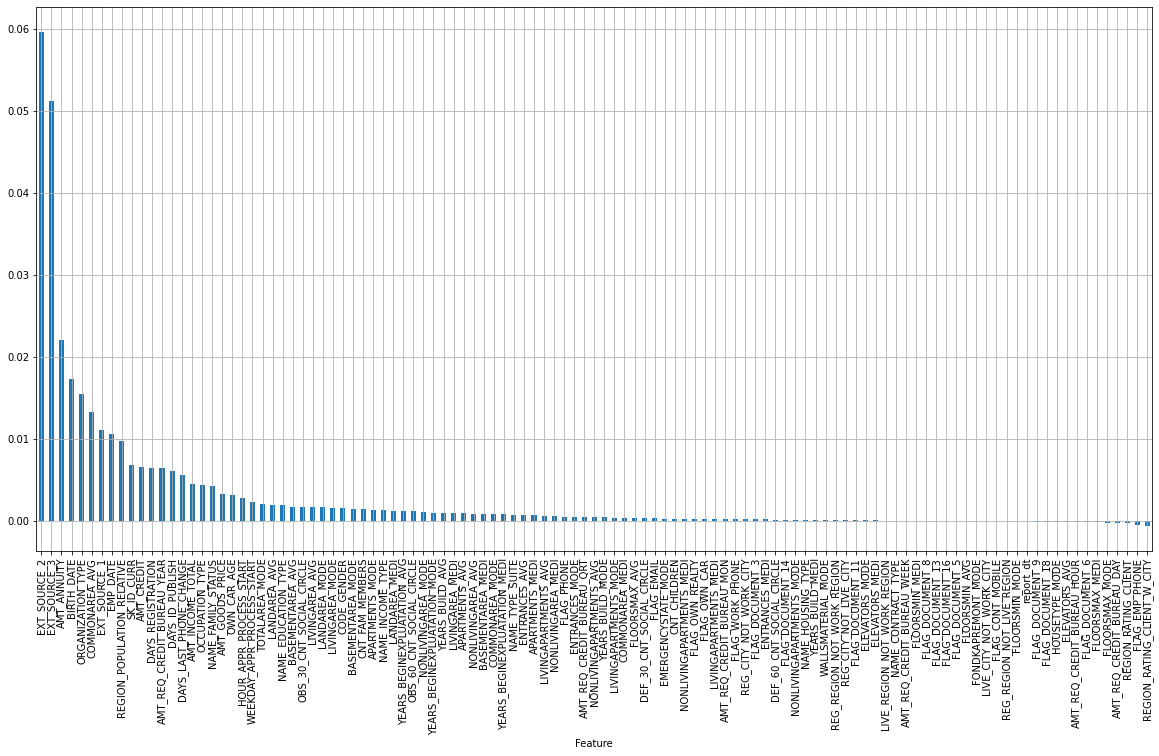

In [61]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast', silent = False)
if fast_fi is None:
    fast_fi = automl.get_feature_scores('accurate', train_data, silent=False)
if fast_fi is not None:
    fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

## Step 6. Predict to test data and check scores for utilized automl

In [62]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-08-30 11:34:11,106] (INFO): Prediction for test data:
array([[0.06294385],
       [0.07479264],
       [0.0314509 ],
       ...,
       [0.06349283],
       [0.05273468],
       [0.21380168]], dtype=float32)
Shape = (2000, 1)
[2021-08-30 11:34:11,107] (INFO): Check scores...
[2021-08-30 11:34:11,111] (INFO): OOF score: 0.7488234209859984
[2021-08-30 11:34:11,114] (INFO): TEST score: 0.7309374999999999


Wall time: 824 ms
